### Library Importing

In [133]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as transforms_v2


%matplotlib inline

In [59]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"You're using {DEVICE.upper()}!")


You're using CUDA:0!


In [60]:
def compile_img_data(partition: str, data_path: str, consider_extensions: set = {'jpg', 'jpeg', 'png'}) -> pd.DataFrame:
    partition_data = []
    for clazz in os.listdir(os.path.join(data_path, partition)):
        for img in os.listdir(os.path.join(data_path, partition, clazz)):
            if img.split('.')[-1] in consider_extensions:
                partition_data.append({'class': clazz, 'img': os.path.join(data_path, partition, clazz, img)})

    return pd.DataFrame(partition_data)


In [61]:
def plot_class_distribution(df: pd.DataFrame, col_name: str, title: str):
    sns.countplot(x=col_name, data=df, order=sorted(df[col_name].unique()))
    plt.title(f'{title} Distribution')
    plt.xticks(rotation=45)
    plt.show()

### Retrieving and Data Preprocessing

In [63]:
BASE_PATH = './data/cat_vs_dog'

In [64]:
train_df = compile_img_data('train', BASE_PATH)
test_df = compile_img_data('test', BASE_PATH)
val_df = compile_img_data('validation', BASE_PATH)


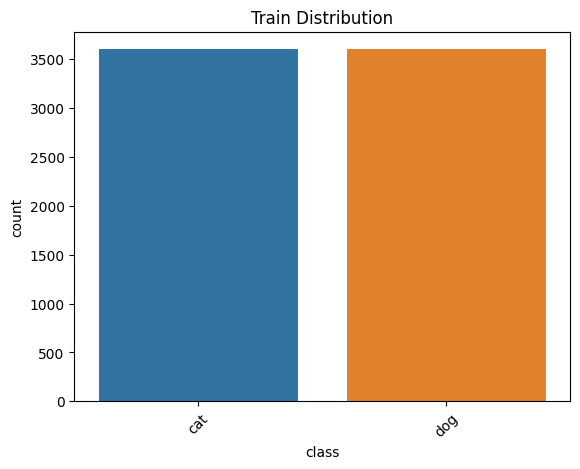

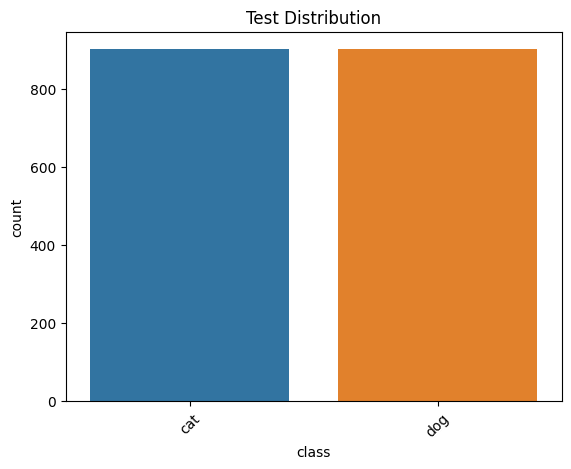

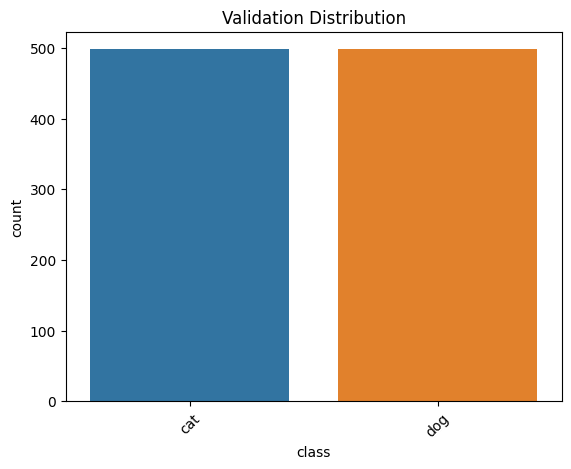

In [65]:
plot_class_distribution(train_df, 'class', 'Train')
plot_class_distribution(test_df, 'class', 'Test')
plot_class_distribution(val_df, 'class', 'Validation')

In [66]:
# Precisa mudar esse dataset

class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, target: str, img_size: tuple, transform_layers: list = None, shuffle: bool = True) -> None:
        self._data = df
        if shuffle:
            self._shuffle()

        self._transform = self._generate_transforms(img_size, transform_layers)
        self._class_names = sorted(self._data[target].unique())

    @property
    def class_names(self) -> list:
        return self._class_names

    @property
    def data(self) -> pd.DataFrame:
        return self._data

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> tuple:
        img = self._transform(read_image(self._data.loc[idx, 'img'])[:3, :, :])
        label = self._class_names.index(self._data.loc[idx, 'class'])

        return img, label

    def _shuffle(self) -> None:
        self._data = self._data.sample(frac=1).reset_index(drop=True)

    def _generate_transforms(self, img_size: tuple, transform_layers: list) -> transforms_v2.Compose:
        transforms = [
            transforms_v2.ToDtype(torch.float32, scale=True),
            transforms_v2.Resize(size=img_size, antialias=True)
        ]

        if transform_layers:
            transforms = list(set(transforms).union(set(transform_layers)))

        return transforms_v2.Compose(transforms)


In [67]:
train_dataset = ImageDataset(train_df, 'class', (224, 224), [transforms_v2.RandomRotation(degrees=(-45, 45)),
                                                            transforms_v2.RandomHorizontalFlip(p=0.5)])
test_dataset = ImageDataset(test_df, 'class', (224, 224))
val_dataset = ImageDataset(val_df, 'class', (224, 224))

This is an instance from dog.


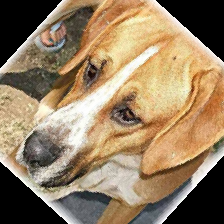

In [68]:
print(f'This is an instance from {train_dataset.class_names[train_dataset[0][1]]}.', end='\n')
transforms_v2.ToPILImage()(train_dataset[0][0])

### Model Architecture Definition

In [69]:
torch.manual_seed(1)

class DefaultImageClassificationNet(nn.Module):

    def __init__(self, n_classes: int) -> None:
        super(DefaultImageClassificationNet, self).__init__()

        self.pool = nn.MaxPool2d((2, 2))

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.batch3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.batch4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, 3)
        self.batch5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3)
        self.batch6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 24 * 24, 128)
        self.batch7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = F.relu(self.conv4(x))
        x = self.batch4(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = self.batch5(x)
        x = F.relu(self.conv6(x))
        x = self.batch6(x)
        x = self.pool(x)
        x = self.dropout3(x)

        x = x.view(-1, 128 * 24 * 24)

        x = F.relu(self.fc1(x))
        x = self.batch7(x)
        x = self.dropout4(x)
        x = self.out(x)

        return x


### Model Training

In [88]:
def calc_validation_perform(model: nn.Module,criterion: nn.Module, val_loader: DataLoader, ) -> float:
    model.eval()

    total_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            batch_loss = criterion(outputs, labels).item()
            total_loss += batch_loss

    return total_loss / len(val_loader)


In [89]:
def print_progress_bar(step, total_steps):
    completion_percentage = (step + 1) / total_steps * 100
    formatted_completion_percentage = math.floor(completion_percentage / 3.333)

    return  f'[{"="*(formatted_completion_percentage)}{"."*(30 - formatted_completion_percentage)}]'


In [97]:
def optimize(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, train_loader: DataLoader, val_loader: DataLoader = None, epochs=10, save_path='./model.pt'):
    model.to(DEVICE)
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()

        total_loss = 0
        print(f'Epoch: {epoch}/{epochs}')

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            imgs, labels = batch
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            print(f'\r{i+1}/{len(train_loader)} {print_progress_bar(i, len(train_loader))} - Loss: {loss:.6f}', end='', flush=True)

        train_losses.append(total_loss / len(train_loader))
        print(f' | Train Loss: {train_losses[-1]:.4f}', end='')
        if val_loader:
            val_losses.append(calc_validation_perform(model, criterion, val_loader))
            print(f' - Val Loss: {val_losses[-1]:.4f}')
        else:
            print()

    torch.save(model.state_dict(), save_path)

    print(f'Completed! =)\nCheck your model saved at {save_path}')

    return {'train': train_losses, 'validation': val_losses}


In [98]:
model = DefaultImageClassificationNet(len(train_dataset.class_names))

model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [99]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [100]:
N_WORKERS = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

In [104]:
history = optimize(model, criterion, optimizer, train_loader, val_loader, epochs=10, save_path='./models/model.pt')

Epoch: 1/10
226/226 [==============================] - Loss: 0.379128 | Train Loss: 0.4015 - Val Loss: 0.5487
Epoch: 2/10
226/226 [==============================] - Loss: 0.037702 | Train Loss: 0.3856 - Val Loss: 0.3989
Epoch: 3/10
226/226 [==============================] - Loss: 0.899182 | Train Loss: 0.3750 - Val Loss: 0.4004
Epoch: 4/10
226/226 [==============================] - Loss: 1.127860 | Train Loss: 0.3597 - Val Loss: 0.3380
Epoch: 5/10
226/226 [==============================] - Loss: 1.792743 | Train Loss: 0.3398 - Val Loss: 0.3014
Epoch: 6/10
226/226 [==============================] - Loss: 0.005324 | Train Loss: 0.3232 - Val Loss: 0.2965
Epoch: 7/10
226/226 [==============================] - Loss: 2.014837 | Train Loss: 0.3189 - Val Loss: 0.2619
Epoch: 8/10
226/226 [==============================] - Loss: 0.054578 | Train Loss: 0.2928 - Val Loss: 0.3015
Epoch: 9/10
226/226 [==============================] - Loss: 1.807663 | Train Loss: 0.2999 - Val Loss: 0.2337
Epoch: 10/

In [108]:
def plot_learning_curve(losses: dict, num_epochs: int = 100, size: tuple = (8, 5), meta: dict = {
        'train': {
            'title': 'Training Loss',
            'color': '#ff5a7d'
        },
        'validation': {
            'title': 'Validation Loss',
            'color': '#ff9e00'
        }
    }) -> None:

    plt.figure(figsize=size)
    num_epochs = min(len(losses['train']), num_epochs)
    for loss_group in losses:
      plt.plot(range(1, num_epochs + 1), losses[loss_group], marker='o', linestyle='-', color=meta[loss_group]['color'], label=meta[loss_group]['title'])

    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()


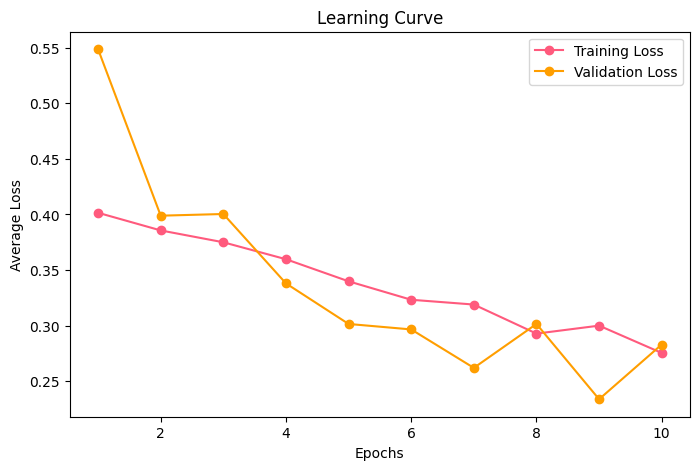

In [111]:
plot_learning_curve(history)

### Model Evaluation

In [130]:
# Permitir definir o dispositivo de avaliação
def evaluate(model, dataloader):
  model.eval()

  predictions, reference, probabilities = [], [], []

  with torch.no_grad():
    for i, batch in enumerate(dataloader):
      imgs, labels = batch
      imgs = imgs.to(DEVICE)
      labels = labels.to(DEVICE)

      logits = model(imgs).data
      y_hat = torch.argmax(logits, 1)

      predictions.extend(y_hat.cpu().numpy())
      reference.extend(labels.cpu().numpy())
      probabilities.extend(torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy())

      print(f'\r{i+1}/{len(dataloader)} {print_progress_bar(i, len(dataloader))}', end='', flush=True)

    return predictions, reference, probabilities


In [131]:
preds = evaluate(model, test_loader)

57/57 [==============================]

In [137]:
print(f'Model accuracy: {accuracy_score(preds[1], preds[0]) * 100:.2f}%.')

Model accuracy: 86.96%.
